Epoch: 0  loss: 1.9461  val_loss: 1.9478  val_acc: 0.1420
Epoch: 1  loss: 1.9316  val_loss: 1.9395  val_acc: 0.2840
Epoch: 2  loss: 1.9054  val_loss: 1.9283  val_acc: 0.3060
Epoch: 3  loss: 1.8705  val_loss: 1.9118  val_acc: 0.3080
Epoch: 4  loss: 1.8191  val_loss: 1.8867  val_acc: 0.3440
Epoch: 5  loss: 1.7574  val_loss: 1.8535  val_acc: 0.4420
Epoch: 6  loss: 1.6864  val_loss: 1.8129  val_acc: 0.5120
Epoch: 7  loss: 1.6094  val_loss: 1.7781  val_acc: 0.5520
Epoch: 8  loss: 1.5293  val_loss: 1.7438  val_acc: 0.5700
Epoch: 9  loss: 1.4745  val_loss: 1.6903  val_acc: 0.5800
Epoch: 10  loss: 1.4307  val_loss: 1.6770  val_acc: 0.5820
Epoch: 11  loss: 1.3836  val_loss: 1.6287  val_acc: 0.5720
Epoch: 12  loss: 1.3535  val_loss: 1.6088  val_acc: 0.5940
Epoch: 13  loss: 1.3043  val_loss: 1.5747  val_acc: 0.6100
Epoch: 14  loss: 1.2864  val_loss: 1.5543  val_acc: 0.6780
Epoch: 15  loss: 1.2584  val_loss: 1.4936  val_acc: 0.6960
Epoch: 16  loss: 1.2399  val_loss: 1.4703  val_acc: 0.7580
Epoch: 

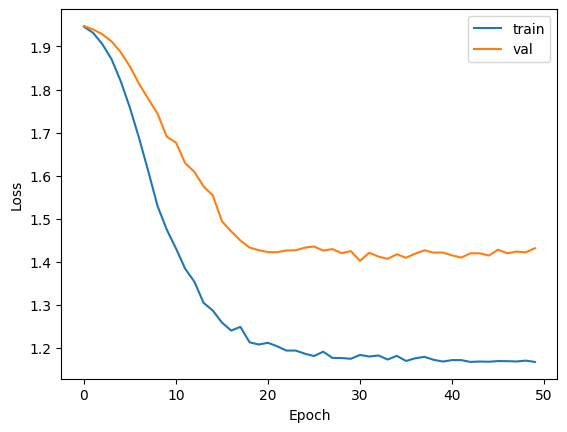

In [13]:
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

# Define the network used, layer 3 GCN
class GCN_NET3(torch.nn.Module):
    def __init__(self, num_features, hidden_size1, hidden_size2, classes):
        super(GCN_NET3, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_size1)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.conv2 = GCNConv(hidden_size1, hidden_size2)
        self.conv3 = GCNConv(hidden_size2, classes)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, Graph):
        x, edge_index = Graph.x, Graph.edge_index
        out = self.conv1(x, edge_index)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out, edge_index)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv3(out, edge_index)
        out = self.softmax(out)
        return out

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

dataset = Planetoid(root='./', name='Cora')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_NET3(dataset.num_node_features, 128, 64, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

eval_T = 5
P = 3
i = 0
max_epoch = 300
setup_seed(seed=20)
temp_val_loss = 99999
L = []
L_val = []

model.train()
for epoch in range(max_epoch):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    _, val_pred = model(data).max(dim=1)
    loss_val = F.cross_entropy(out[data.val_mask], data.y[data.val_mask])

    if (epoch % eval_T) == 0:
        if (temp_val_loss > loss_val):
            temp_val_loss = loss_val
            torch.save(model.state_dict(), "GCN_NET3.pth")
            i = 0
        else:
            i = i + 1
    if i > P:
        print("Early Stopping! Epoch: ", epoch)
        break

    L_val.append(loss_val.detach().item())
    val_correct = val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    val_acc = val_correct / data.val_mask.sum()
    print('Epoch: {}  loss: {:.4f}  val_loss: {:.4f}  val_acc: {:.4f}'.format(epoch, loss.item(),
                                                                               loss_val.item(), val_acc.item()))
    L.append(loss.detach().item())
    loss.backward()
    optimizer.step()

model.load_state_dict(torch.load("GCN_NET3.pth"))
model.eval()
_, pred = model(data).max(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc = correct / data.test_mask.sum()
print("Test accuracy is {:.4f}".format(acc.item()))

n = [i for i in range(len(L))]
plt.plot(n, L, label='train')
plt.plot(n, L_val, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Epoch: 0  loss: 1.9505  val_loss: 1.9634  val_acc: 0.1420
Epoch: 1  loss: 1.8634  val_loss: 1.9119  val_acc: 0.2980
Epoch: 2  loss: 1.7318  val_loss: 1.8554  val_acc: 0.3580
Epoch: 3  loss: 1.5861  val_loss: 1.7876  val_acc: 0.3920
Epoch: 4  loss: 1.4073  val_loss: 1.6870  val_acc: 0.4580
Epoch: 5  loss: 1.2098  val_loss: 1.5732  val_acc: 0.5340
Epoch: 6  loss: 1.0050  val_loss: 1.4416  val_acc: 0.6180
Epoch: 7  loss: 0.8128  val_loss: 1.3232  val_acc: 0.6720
Epoch: 8  loss: 0.6205  val_loss: 1.1960  val_acc: 0.6940
Epoch: 9  loss: 0.4832  val_loss: 1.0528  val_acc: 0.7440
Epoch: 10  loss: 0.3890  val_loss: 1.0079  val_acc: 0.7620
Epoch: 11  loss: 0.2906  val_loss: 0.8473  val_acc: 0.7540
Epoch: 12  loss: 0.2143  val_loss: 0.8403  val_acc: 0.7440
Epoch: 13  loss: 0.1470  val_loss: 0.8385  val_acc: 0.7700
Epoch: 14  loss: 0.1126  val_loss: 0.8609  val_acc: 0.7520
Epoch: 15  loss: 0.0866  val_loss: 0.8240  val_acc: 0.7460
Epoch: 16  loss: 0.0673  val_loss: 0.8860  val_acc: 0.7620
Epoch: 

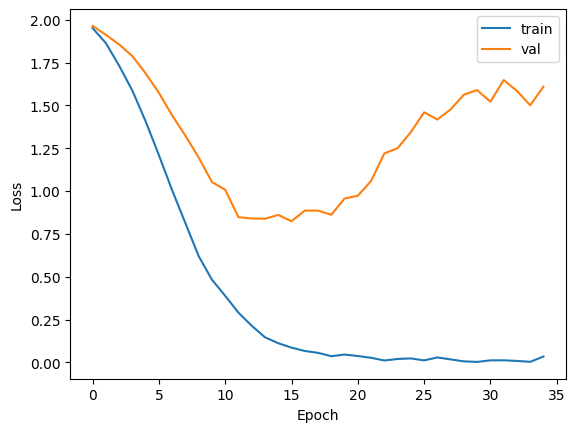

In [15]:
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

# Define the network used, layer 3 GCN
class GCN_NET3(torch.nn.Module):
    def __init__(self, num_features, hidden_size1, hidden_size2, classes):
        super(GCN_NET3, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_size1)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.conv2 = GCNConv(hidden_size1, hidden_size2)
        self.conv3 = GCNConv(hidden_size2, classes)

    def forward(self, Graph):
        x, edge_index = Graph.x, Graph.edge_index
        out = self.conv1(x, edge_index)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out, edge_index)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv3(out, edge_index)
        return out

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

dataset = Planetoid(root='./', name='Cora')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_NET3(dataset.num_node_features, 128, 64, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

eval_T = 5
P = 3
i = 0
max_epoch = 300
setup_seed(seed=20)
temp_val_loss = 99999
L = []
L_val = []

model.train()
for epoch in range(max_epoch):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    _, val_pred = model(data).max(dim=1)
    loss_val = F.cross_entropy(out[data.val_mask], data.y[data.val_mask])

    if (epoch % eval_T) == 0:
        if (temp_val_loss > loss_val):
            temp_val_loss = loss_val
            torch.save(model.state_dict(), "GCN_NET3.pth")
            i = 0
        else:
            i = i + 1
    if i > P:
        print("Early Stopping! Epoch: ", epoch,)
        break

    L_val.append(loss_val.detach().item())
    val_correct = val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    val_acc = val_correct / data.val_mask.sum()
    print('Epoch: {}  loss: {:.4f}  val_loss: {:.4f}  val_acc: {:.4f}'.format(epoch, loss.item(),
                                                                               loss_val.item(), val_acc.item()))
    L.append(loss.detach().item())
    loss.backward()
    optimizer.step()

model.load_state_dict(torch.load("GCN_NET3.pth"))
model.eval()
_, pred = model(data).max(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc = correct / data.test_mask.sum()
print("Test accuracy is {:.4f}".format(acc.item()))

n = [i for i in range(len(L))]
plt.plot(n, L, label='train')
plt.plot(n, L_val, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
